In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import glob
from IPython.display import display, clear_output
from IPython.display import Image as ImgDisplay

from PIL import Image

In [4]:
import os
#relocate to desktop
os.chdir("/Users/iqra/Desktop")

In [5]:
#converting videos to frames
vidcap = cv2.VideoCapture('./vid.mp4')

def getFrame(sec, count):
  vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
  hasFrames,image = vidcap.read()
  if hasFrames:
    cv2.imwrite("./img/image"+str(count).zfill(3)+".jpg", image)
  return hasFrames

frameRate = 0.1 # capture one image in each x seconds

count = 0
sec = 0
success=True

while success:
    count += 1
    sec = round(sec + frameRate, 2)
    success = getFrame(sec, count)

In [6]:
#figuring out how many files there are in each folder
#to ensure balanced datasets
def how_many_files_in_folder(path):
    files = glob.glob(path)
    nb_files = len(files)
    return nb_files, files

folders = ["0_sunrise","1_afternoon","2_night","3_sunset"]
nb_files_total = 0

for folder in folders:
    path = "/Users/iqra/Desktop/"+folder+"/*.jpg"
    nb_files, files = how_many_files_in_folder(path)
    nb_files_total += nb_files
    print("Number of files in "+folder+":", nb_files)

print("Total Number of files:", nb_files_total)

Number of files in 0_sunrise: 64
Number of files in 1_afternoon: 169
Number of files in 2_night: 219
Number of files in 3_sunset: 88
Total Number of files: 540


In [7]:
#This function will convert each image to a numpy array
def img_to_data(path):
  
    img = Image.open(path)
    img.load()
    img = img.resize((260, 180))
    data = np.asarray(img, dtype="int32")

    return data

(180, 260, 3)


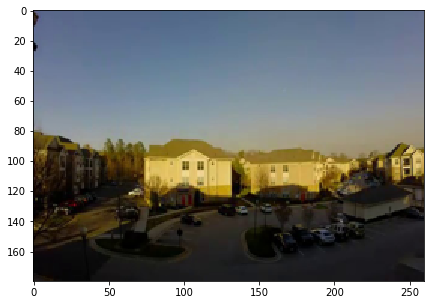

In [8]:
img_sample = img_to_data(files[0])
print(img_sample.shape)

picture_y = img_sample.shape[0]
picture_x = img_sample.shape[1]

plt.figure(figsize = (7,10))
plt.imshow(img_sample)
plt.show()

In [9]:
#data_collect_RGB has the 4D array of the files, targer_collect 
#will only have the names, so it is a simple vector.
data_collect_RGB = np.ndarray(shape=(nb_files_total,picture_y,picture_x,3),  dtype=int)
target_collect = np.ndarray(shape=(nb_files_total,1),  dtype=int)


idx=0

for folder in folders:
    path = "/Users/iqra/Desktop/"+folder+"/*.jpg"
    
    nb_files, files = how_many_files_in_folder(path)
    current_target = folder[0]
    
    for img in files:
    
        data_collect_RGB[idx] = img_to_data(img)
        target_collect[idx] = current_target
        
        
        idx+=1

print ("All pictures converted!")
np.save('/Users/iqra/Desktop/data_collect_RGB.npy', data_collect_RGB)
np.save('/Users/iqra/Desktop//target_collect.npy', target_collect)

All pictures converted!


In [10]:
#creating deep learning model from arrays
import tensorflow as tf

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation

from sklearn.model_selection import train_test_split

In [12]:
data_collect_RGB = np.load('/Users/iqra/Desktop/data_collect_RGB.npy')
print(data_collect_RGB.shape)
target_collect = np.load('/Users/iqra/Desktop//target_collect.npy')
print(target_collect.shape)
num_classes = len(np.unique(target_collect))
print("num_classes:", num_classes)

(540, 180, 260, 3)
(540, 1)
num_classes: 4


In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(data_collect_RGB, target_collect, random_state=42)

In [14]:
model = tf.keras.Sequential([
    Flatten(input_shape=(X_train.shape[1], X_train.shape[2],3)),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes),
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=7,
          validation_data=(X_valid, y_valid),
          );

Epoch 1/7
13/13 [==============================] - 7s 383ms/step - loss: 4687.2629 - accuracy: 0.5177 - val_loss: 800.5498 - val_accuracy: 0.8593
Epoch 2/7
13/13 [==============================] - 4s 334ms/step - loss: 643.4122 - accuracy: 0.9061 - val_loss: 388.1370 - val_accuracy: 0.9333
Epoch 3/7
13/13 [==============================] - 5s 370ms/step - loss: 449.1509 - accuracy: 0.9307 - val_loss: 212.7931 - val_accuracy: 0.9630
Epoch 4/7
13/13 [==============================] - 4s 327ms/step - loss: 122.2367 - accuracy: 0.9685 - val_loss: 188.6393 - val_accuracy: 0.9778
Epoch 5/7
13/13 [==============================] - 4s 319ms/step - loss: 88.5241 - accuracy: 0.9786 - val_loss: 151.2037 - val_accuracy: 0.9778
Epoch 6/7
13/13 [==============================] - 4s 331ms/step - loss: 204.9796 - accuracy: 0.9674 - val_loss: 174.8313 - val_accuracy: 0.9704
Epoch 7/7
13/13 [==============================] - 4s 277ms/step - loss: 97.3024 - accuracy: 0.9809 - val_loss: 204.9915 - val_acc

In [15]:
#the accuracy we get from the 6th and 7th epochs is 97.04%, which is more than good enough.

def plot_figures(figures, nrows = 1, ncols=1):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    fig.set_figheight(10)
    fig.set_figwidth(20)

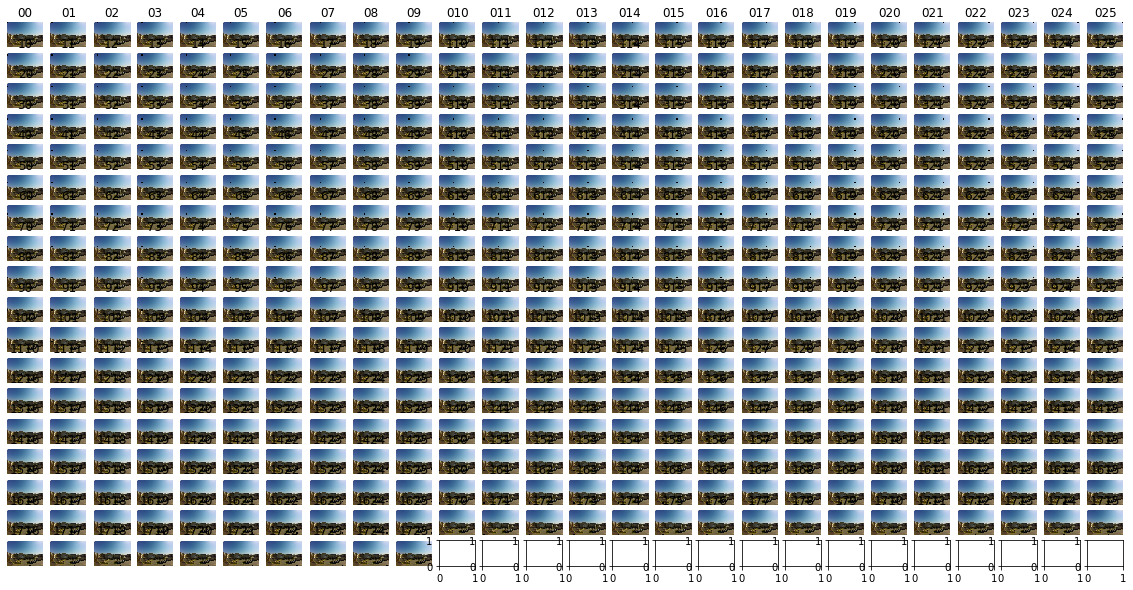

In [16]:
img_original = X_valid[5].astype(np.uint8) #morning

#dictionary to store the black-boxed pictures
img_to_show = {}

# We define the size of the black boxes, 1/10th of height and width
step = 10
# and the corresponding number of step to run on the picture 
step_nb_x = math.ceil(img_original.shape[1] / step)
step_nb_y = math.ceil(img_original.shape[0] / step)

for step_y in range(step_nb_y):
  for step_x in range(step_nb_x):
    
    # At every step, we create a new img_spl_black array
    # to avoid array_A = array_B reversability
    img_spl_black = img_original.copy()
  
    # We apply "0" (= black) on the black box location
    img_spl_black[step_y*step:step_y*step+step,step_x*step:step_x*step+step]=0
    
    # We create an index to store the corresponding array
    idx = str(step_y)+str(step_x)
    img_to_show[idx] = img_spl_black

plot_figures(img_to_show, step_nb_y, step_nb_x)

In [17]:
error_logs = pd.DataFrame(index=list(img_to_show))

# We store the prediction probabilities from the original picture
original_prediction = model.predict(img_original[np.newaxis, :,:]/255)
original_idx_prediction = np.argmax(original_prediction) 

# For each black-boxed picture
for idx in img_to_show:

  img_tmp = img_to_show[idx]/255
  img_tmp = img_tmp[np.newaxis, :,:]
  
  #store the prediction probabilities
  tmp_prediction = model.predict(img_tmp)
  tmp_idx_prediction = np.argmax(tmp_prediction)
  
  #calculate and store the probability difference between the original and black-boxed picture
  tmp_error = original_prediction[0,original_idx_prediction]-tmp_prediction[0,original_idx_prediction]
  error_logs.loc[idx,"error"]=tmp_error

In [18]:
# The shades will go from full red to black
rgb_shade = 255

# We display the red gradient decrease at every step
red_distance_step = rgb_shade / len(img_to_show)
print("red_distance_step: {:.2f}".format(red_distance_step))

# We sort the error logs with the highest error first 
error_logs_desc_sort = error_logs.sort_values(by="error", ascending=True)


# We assign a red shade with decreasing intensity to each box
for idx in error_logs_desc_sort.index:
  error_logs_desc_sort.loc[idx,"rgb_shade"]=rgb_shade
  rgb_shade-=red_distance_step

img_original_RGB_red_shades = img_original.copy()

for step_y in range(step_nb_y):
  for step_x in range(step_nb_x):

    # We update each box of the picture with its corresponding red shade
    idx = str(step_y)+str(step_x)
    img_original_RGB_red_shades[step_y*step:step_y*step+step,step_x*step:step_x*step+step,0]=error_logs_desc_sort.loc[idx,"rgb_shade"]
    img_original_RGB_red_shades[:,:,1]=0
    img_original_RGB_red_shades[:,:,2]=0

red_distance_step: 0.56


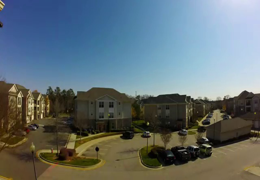

In [19]:
Image.fromarray(img_original.astype(np.uint8))

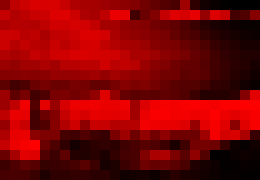

In [20]:
Image.fromarray(img_original_RGB_red_shades.astype(np.uint8))

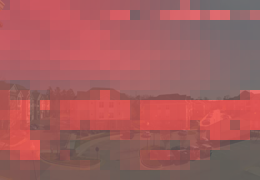

In [21]:
#adding transparency to see the location relative to the reds and blacks
# add layer to the original picture with a 100/255 transparency ratio
img_original_alpha = np.zeros((180,260,4), dtype=np.uint8)
img_original_alpha[:,:,0:3]=img_original
img_original_alpha[:,:,3]=100

# layer to the red shades picture with a 200/255 transparency ratio
img_original_RGB_red_shades_alpha = np.zeros((180,260,4), dtype=np.uint8)
img_original_RGB_red_shades_alpha[:,:,0:3]=img_original_RGB_red_shades
img_original_RGB_red_shades_alpha[:,:,3]=200

# We combine the two pictures and display the output
background = Image.fromarray(img_original_alpha)
foreground = Image.fromarray(img_original_RGB_red_shades_alpha)
background.paste(foreground, (0, 0), foreground)
background